# Environmental Sensor with Three Different Algorithms
## Anomarlly Detection, Regression and Classification 

### Import and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

### Data Loading and Exploration

In [2]:
df = pd.read_csv('feeds.csv')

print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows: \n", df.head())
print("\nData types:\n", df.dtypes)
print("\nBasic stats:\n", df.describe())

Shape: (17819, 10)
Columns: ['created_at', 'entry_id', 'temperature', 'humidity', 'light_level', 'tilt_status', 'latitude', 'longitude', 'elevation', 'status']

First 5 rows: 
                   created_at  entry_id  temperature  humidity light_level  \
0  2025-07-12T15:58:07+00:00         1           25        60    13.58297   
1  2025-07-12T15:58:27+00:00         2           25        60    15.35546   
2  2025-07-12T15:58:58+00:00         3           25        58    12.53559   
3  2025-07-12T15:59:18+00:00         4           25        58    15.51659   
4  2025-07-12T15:59:39+00:00         5           25        58        16.0   

   tilt_status  latitude  longitude  elevation  status  
0     18.99901       NaN        NaN        NaN     NaN  
1     18.31388       NaN        NaN        NaN     NaN  
2     18.97459       NaN        NaN        NaN     NaN  
3     18.60685       NaN        NaN        NaN     NaN  
4     18.80369       NaN        NaN        NaN     NaN  

Data types:
 crea

### Data Cleaning
- #### Missing Values, Drop Columns with 100% Missing Values and Datarime Features

In [3]:
# Missing Values
missing_values = df.isnull().sum()
missing_percentage = (missing_values/len(df) * 100)
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Percentage': missing_percentage})
print("Missing values:\n", missing_df)

# Drop Column with 100% Missing Values
columns_to_drop = missing_df[missing_df['Percentage']== 100].index.tolist()
df_cleaned = df.drop(columns=columns_to_drop)

print(f"\nDropped: {columns_to_drop}")
print(f"New Shape: {df_cleaned.shape}")

# Datetime Features
df_cleaned['created_at']= pd.to_datetime(df_cleaned['created_at'])
df_cleaned['year']= df_cleaned['created_at'].dt.year
df_cleaned['month']= df_cleaned['created_at'].dt.month
df_cleaned['day']= df_cleaned['created_at'].dt.day
df_cleaned['hour']= df_cleaned['created_at'].dt.hour
df_cleaned['minute']= df_cleaned['created_at'].dt.minute
df_cleaned['day_of_week']= df_cleaned['created_at'].dt.dayofweek
df_cleaned['day_of_year']= df_cleaned['created_at'].dt.dayofyear
print(f"\nDate range: {df_cleaned['created_at'].min()} to {df_cleaned['created_at'].max()}")
print("Temporal features added.")

Missing values:
              Missing Count  Percentage
created_at               0         0.0
entry_id                 0         0.0
temperature              0         0.0
humidity                 0         0.0
light_level              0         0.0
tilt_status              0         0.0
latitude             17819       100.0
longitude            17819       100.0
elevation            17819       100.0
status               17819       100.0

Dropped: ['latitude', 'longitude', 'elevation', 'status']
New Shape: (17819, 6)

Date range: 2025-07-12 15:58:07+00:00 to 2025-10-26 15:35:57+00:00
Temporal features added.


- #### Clean light_level Column and Dublicates

In [4]:
non_numeric = df_cleaned[pd.to_numeric(df_cleaned['light_level'], errors='coerce').isna()]['light_level'].unique()
print(f"\nNon-numeric 'light_level': {non_numeric}")
df_cleaned['light_level'] = pd.to_numeric(df_cleaned['light_level'], errors='coerce')
nan_count = df_cleaned['light_level'].isna().sum()
if nan_count > 0:
    median_light = df_cleaned['light_level'].median()
    df_cleaned['light_level'].fillna(median_light, inplace=True)
    print(f"Filled {nan_count} NaNs in 'light_level' with median value: {median_light:.2f}")

df_cleaned['tilt_status'] = pd.to_numeric(df_cleaned['tilt_status'], errors='coerce')
outliers = (df_cleaned['tilt_status'] > 1).sum()
median_tilt = df_cleaned['tilt_status'].median() 
if outliers > 0:
    df_cleaned.loc[df_cleaned['tilt_status'] > 1, 'tilt_status'] = median_tilt 
df_cleaned['tilt_status'] = df_cleaned['tilt_status'].fillna(0).clip(lower=0, upper=1).astype(int)  
print(f"Replaced {outliers} outliers (>1) w/ median {median_tilt}. Post-fix: {df_cleaned['tilt_status'].value_counts().to_dict()}")

# Duplicates
duplicate_count = df_cleaned.duplicated().sum()
if duplicate_count > 0:
    df_cleaned = df_cleaned.drop_duplicates()
    print(f"\nDropped {duplicate_count} duplicate rows.")

# Save cleaned data
sensor_cols = ['temperature', 'humidity', 'light_level', 'tilt_status']  # Fixed name
print("\nSensor stats:\n", df_cleaned[sensor_cols].describe())
df_cleaned.to_csv('feeds_cleaned.csv', index=False)


Non-numeric 'light_level': ['()']
Filled 331 NaNs in 'light_level' with median value: 25.40
Replaced 511 outliers (>1) w/ median 1.0. Post-fix: {1: 17804, 0: 15}

Sensor stats:
         temperature      humidity   light_level   tilt_status
count  17819.000000  17819.000000  17819.000000  17819.000000
mean      22.648016     49.190976     19.974931      0.999158
std        2.885672      7.143704     10.810535      0.029002
min       20.000000     10.000000      0.292973      0.000000
25%       21.000000     45.000000     18.728924      1.000000
50%       21.000000     49.000000     25.397116      1.000000
75%       25.000000     54.000000     26.837568      1.000000
max       41.000000     71.000000     97.119100      1.000000


## Isolation Forest Algorithm

In [5]:
class IsolationTree:
    def __init__(self, height_limit):
        self.height_limit = height_limit
        self.split_feature = None
        self.split_value = None
        self.left = None
        self.right = None
        self.size = 0
        self.is_external = False

    def fit(self, X, current_height=0):
        self.size = len(X)
        if current_height >= self.height_limit or len(X) <= 1:
            self.is_external = True
            return self
        if len(np.unique(X, axis=0)) == 1:
            self.is_external = True
            return self
        n_features = X.shape[1]
        self.split_feature = np.random.randint(0, n_features)
        feature_values = X[:, self.split_feature]
        min_val, max_val = feature_values.min(), feature_values.max()
        if min_val == max_val:
            self.is_external = True
            return self
        self.split_value = np.random.uniform(min_val, max_val)
        left_mask = feature_values < self.split_value
        right_mask = ~left_mask
        if left_mask.sum()> 0:
            self.left = IsolationTree(self.height_limit)
            self.left.fit(X[left_mask], current_height + 1)
        if right_mask.sum() > 0:
            self.right = IsolationTree(self.height_limit)
            self.right.fit(X[right_mask], current_height + 1)
        return self
    
    def path_length(self, x, current_height=0):
        if self.is_external:
            return current_height + self._c(self.size)
        if x[self.split_feature] < self.split_value:
            return self.left.path_length(x, current_height + 1) if self.left else current_height + 1
        else:
            return self.right.path_length(x, current_height + 1) if self.right else current_height + 1
        
    def _c(self, n):
        if n <= 1:
            return 0
        else:
            return 2 * (np.log(n - 1) + 0.5772156649) - (2 * (n - 1) / n)
        
class IsolationForest:
    def __init__(self, n_trees=50, sample_size=256):
        self.n_trees = n_trees
        self.sample_size = sample_size
        self.trees = []
        self.height_limit = None

    def fit(self, X):
        n_samples = len(X)  # <-- fix typo here
        self.sample_size = min(self.sample_size, n_samples)
        self.height_limit = int(np.ceil(np.log2(self.sample_size)))
        print(f"Training IF: {self.n_trees} trees, sample size: {self.sample_size}, height limit: {self.height_limit}")
        for i in range(self.n_trees):
            sample_indices = np.random.choice(n_samples, self.sample_size, replace=False)
            tree = IsolationTree(self.height_limit)
            tree.fit(X[sample_indices])
            self.trees.append(tree)
            if (i+1) % 10 == 0:
                print(f"  Trees: {i+1}/{self.n_trees} trees")
        return self
    
    def anomaly_score(self, X):
        avg_path = np.mean([tree.path_length(X) for tree in self.trees])
        c = 2 * (np.log(self.sample_size - 1) + 0.5772156649) - (2 * (self.sample_size - 1) / self.sample_size)
        return 2 ** (-avg_path / c)
    
    def predict(self, X):
        return np.array([self.anomaly_score(x) for x in X])

## Train and Evaluate Isolation Forest

Training IF: 50 trees, sample size: 256, height limit: 8
  Trees: 10/50 trees
  Trees: 20/50 trees
  Trees: 30/50 trees
  Trees: 40/50 trees
  Trees: 50/50 trees
Anomalies: 167 (0.9%) | Threshold: 0.6

Score stats:
 count    17819.000000
mean         0.468295
std          0.027846
min          0.441720
25%          0.450357
50%          0.463951
75%          0.474690
max          0.682303
Name: anomaly_score, dtype: float64


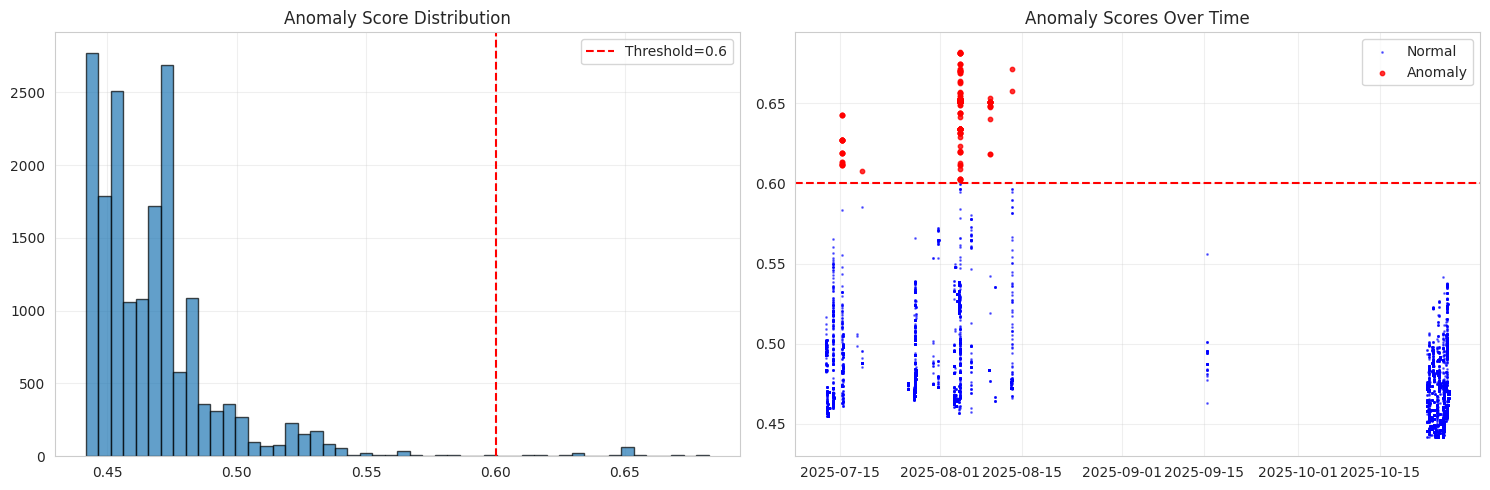


 Top 10 Anomalies:
                     created_at  temperature  humidity  light_level  \
4270 2025-08-04 09:01:25+00:00           41        15     13.30892   
4301 2025-08-04 09:13:54+00:00           40        14     12.84505   
4302 2025-08-04 09:14:18+00:00           40        14     12.40406   
4303 2025-08-04 09:14:42+00:00           40        14     12.33082   
4304 2025-08-04 09:15:06+00:00           40        14     12.64973   
4283 2025-08-04 09:06:38+00:00           40        15     12.86946   
4284 2025-08-04 09:07:03+00:00           40        15     13.23568   
4267 2025-08-04 09:00:12+00:00           41        15     13.52865   
4268 2025-08-04 09:00:36+00:00           41        15     13.67514   
4269 2025-08-04 09:01:01+00:00           41        15     13.52865   

      tilt_status  anomaly_score  
4270            1       0.682303  
4301            1       0.681381  
4302            1       0.681381  
4303            1       0.681381  
4304            1       0.681381 

In [6]:
from sklearn.preprocessing import StandardScaler
# Prepare data for Isolation Forest
sensor_features = ['temperature', 'humidity', 'light_level', 'tilt_status']
X_anomaly = df_cleaned[sensor_features].values
scaler = StandardScaler()
X_anomaly_scaled = scaler.fit_transform(X_anomaly)

# Train and predict
iforest = IsolationForest()
iforest.fit(X_anomaly_scaled)
anomaly_scores = iforest.predict(X_anomaly_scaled)
df_cleaned['anomaly_score'] = anomaly_scores

# Results
threshold = 0.6
df_cleaned['is_anomaly'] = df_cleaned['anomaly_score'] > threshold
n_anomalies = df_cleaned['is_anomaly'].sum()
anomaly_percentage = (n_anomalies / len(df_cleaned)) * 100
print(f"Anomalies: {n_anomalies} ({anomaly_percentage:.1f}%) | Threshold: {threshold}")
print("\nScore stats:\n", df_cleaned['anomaly_score'].describe())

# Plots

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(anomaly_scores, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(threshold, color='red', linestyle='--', label=f'Threshold={threshold}')
axes[0].set_title('Anomaly Score Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(df_cleaned[~df_cleaned['is_anomaly']]['created_at'],df_cleaned[~df_cleaned['is_anomaly']]['anomaly_score'], 
                c ='blue', s=1, label='Normal', alpha=0.5)
axes[1].scatter(df_cleaned[df_cleaned['is_anomaly']]['created_at'],df_cleaned[df_cleaned['is_anomaly']]['anomaly_score'],
                c='red', s=10, label='Anomaly', alpha=0.8)
axes[1].axhline(threshold, color='red', linestyle='--')
axes[1].set_title('Anomaly Scores Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Top 10 Anomalies:\n", df_cleaned.nlargest(10, 'anomaly_score')[['created_at'] + sensor_features + ['anomaly_score']])


## Linear Regression and Metrics

In [7]:
def calculate_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else 0
    return {"MAE": mae, "RMSE": rmse, "R²": r2}

class linearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000, regularization=0.01):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization = regularization
        self.weights = None
        self.bias = None
        self.cost_history = []

    def compute_cost(self, X, y):
        n_samples = len(y)
        predictions = X.dot(self.weights) + self.bias
        mse = (1 / (2 * n_samples)) * np.sum((predictions - y) ** 2)
        reg_term = (self.regularization / (2 * n_samples)) * np.sum(self.weights ** 2)
        return mse + reg_term
    
    def fit(self, X, y, verbose=True):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        if verbose:
            print(f"Training Linear Regression: {n_features} features, {n_samples} samples")

        for iteration in range(self.n_iterations):
            predictions = X.dot(self.weights) + self.bias
            dw = (1 / n_samples) * (X.T.dot(predictions - y)) + (self.regularization / n_samples) * self.weights
            db = (1 / n_samples) * np.sum(predictions - y)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            self.cost_history.append(self.compute_cost(X, y))
            if verbose and (iteration + 1) % 500 == 0:
                print(f"Iteration {iteration + 1}: Cost: {self.cost_history[-1]:.6f}")
        return self
    
    def predict(self, X):
        return X.dot(self.weights) + self.bias
    
class MultiTargetLinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000, regularization=0.01):
        self.lr_temp= linearRegression(learning_rate, n_iterations, regularization)
        self.lr_hum= linearRegression(learning_rate, n_iterations, regularization)

    def fit(self, X, y_temp, y_hum, verbose=True):
        self.lr_temp.fit(X, y_temp, verbose=verbose)
        self.lr_hum.fit(X, y_hum, verbose=False)
        return self
    
    def predict(self, X):
        return np.column_stack([self.lr_temp.predict(X), self.lr_hum.predict(X)])


- ### Prepare Features and Train

In [8]:
def create_lag_features(df, target_cols, lags=[1, 2, 3, 6, 12]):
    for lag in lags:
        df[f'{target_cols}_lag_{lag}'] = df[target_cols].shift(lag)
    return df

def create_rolling_features(df, target_cols, windows=[5, 10, 20]):
    for window in windows:
        df[f'{target_cols}_rolling_mean_{window}'] = df[target_cols].rolling(window).mean()
        df[f'{target_cols}_rolling_std_{window}'] = df[target_cols].rolling(window).std()
    return df

def create_multi_features(df, targets=['temperature', 'humidity'], lags=[1, 2, 3, 6, 12], windows=[5, 10, 20]):
    for target in targets:
        df = create_lag_features(df, target, lags)
        df = create_rolling_features(df, target, windows)
    return df

df_ts_multi = df_cleaned.sort_values('created_at').reset_index(drop=True)
df_ts_multi = create_multi_features(df_ts_multi, targets=['temperature', 'humidity'])
df_ts_multi = df_ts_multi.dropna().reset_index(drop=True)

feature_cols_multi = [
    'temperature_lag_1', 'temperature_lag_2', 'temperature_lag_3', 'temperature_lag_6', 'temperature_lag_12',
    'temperature_rolling_mean_5', 'temperature_rolling_std_5',
    'temperature_rolling_mean_10', 'temperature_rolling_std_10',
    'temperature_rolling_mean_20', 'temperature_rolling_std_20',
    'humidity_lag_1', 'humidity_lag_2', 'humidity_lag_3', 'humidity_lag_6', 'humidity_lag_12',
    'humidity_rolling_mean_5', 'humidity_rolling_std_5',
    'humidity_rolling_mean_10', 'humidity_rolling_std_10',
    'humidity_rolling_mean_20', 'humidity_rolling_std_20', 'hour', 'day_of_week', 'light_level', 'tilt_status'
]
X_multi = df_ts_multi[feature_cols_multi].values
y_temp_multi = df_ts_multi['temperature'].values
y_hum_multi = df_ts_multi['humidity'].values

train_size = int(0.8 * len(df_ts_multi))
X_train_multi, y_train_temp, y_train_hum = X_multi[:train_size], y_temp_multi[:train_size], y_hum_multi[:train_size]
X_test_multi, y_test_temp, y_test_hum = X_multi[train_size:], y_temp_multi[train_size:], y_hum_multi[train_size:]

scaler_X_multi = StandardScaler()
X_train_multi_scaled = scaler_X_multi.fit_transform(X_train_multi)
X_test_multi_scaled = scaler_X_multi.transform(X_test_multi)

print(f"Train: {len(X_train_multi)}, Test: {len(X_test_multi)}")

multi_model = MultiTargetLinearRegression(learning_rate=0.01, n_iterations=2000, regularization=0.1)
multi_model.fit(X_train_multi_scaled, y_train_temp, y_train_hum)

Train: 14240, Test: 3560
Training Linear Regression: 26 features, 14240 samples
Iteration 500: Cost: 0.050774
Iteration 1000: Cost: 0.030839
Iteration 1500: Cost: 0.027303
Iteration 2000: Cost: 0.025354


- ### Evaluate Single-step Predictions and Metrics for both Temperature and Humidity

Test Metrics (Temp): MAE 0.0405°C, RMSE 0.0871°C, R² 0.8958
Test Metrics (Hum): MAE 0.1174, RMSE 0.2545, R² 0.9971

Residuals - Temp: Mean 0.0155, Std 0.0857, p-norm 0.0000
Hum: Mean -0.0423, Std 0.2510, p-norm 0.0000


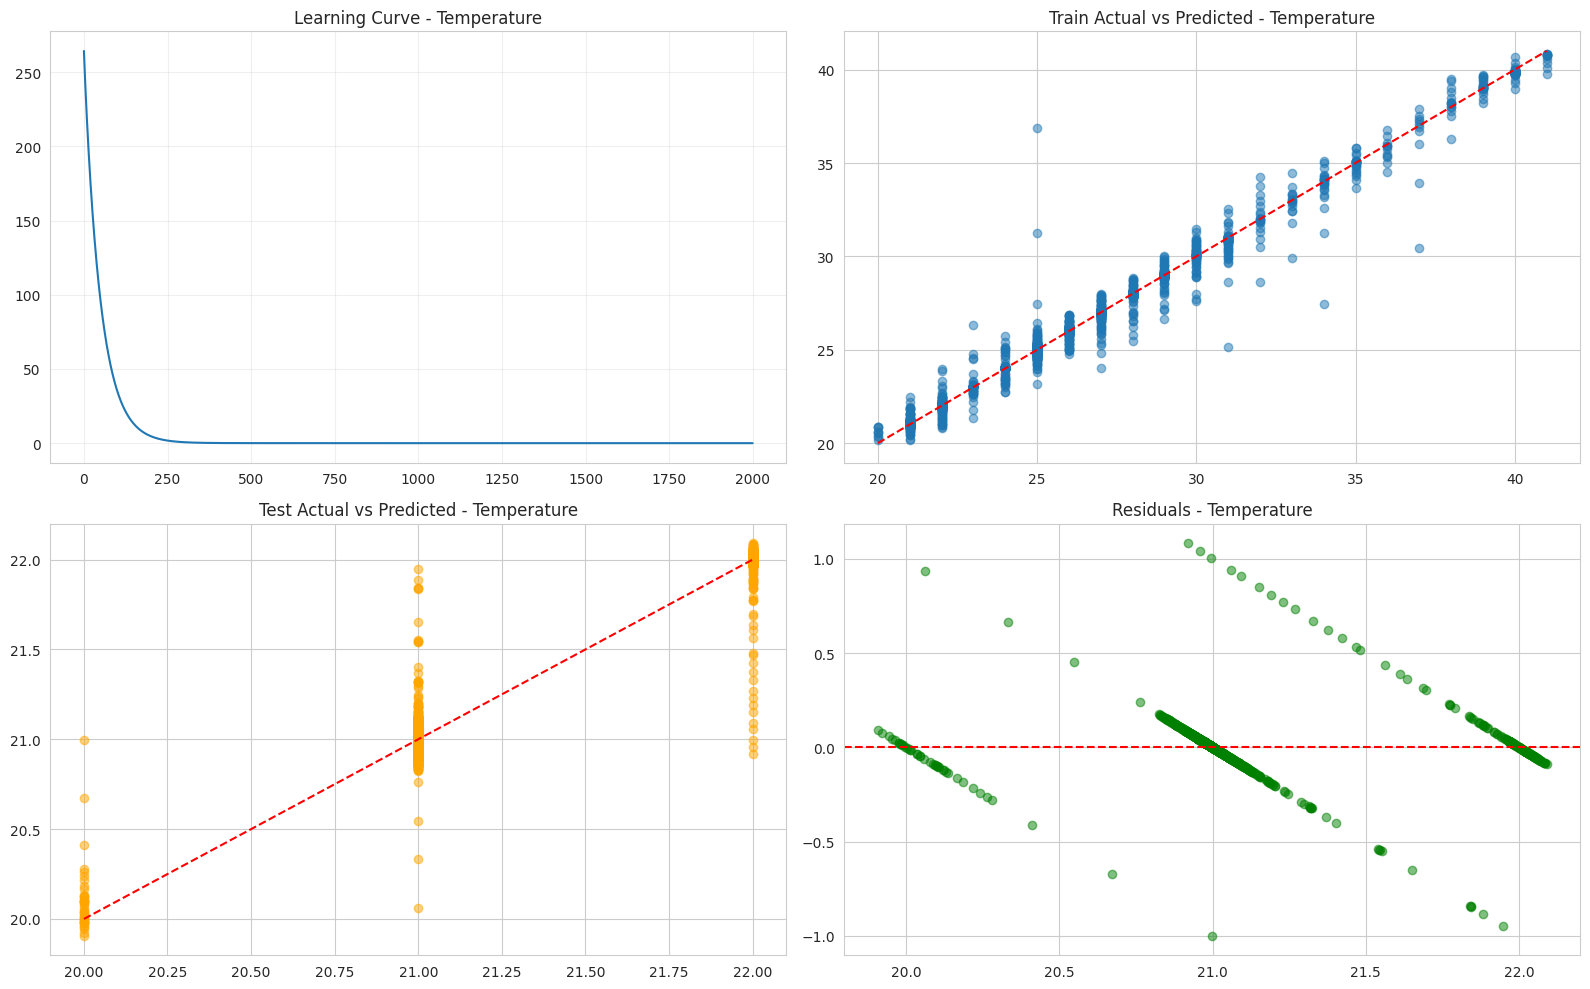

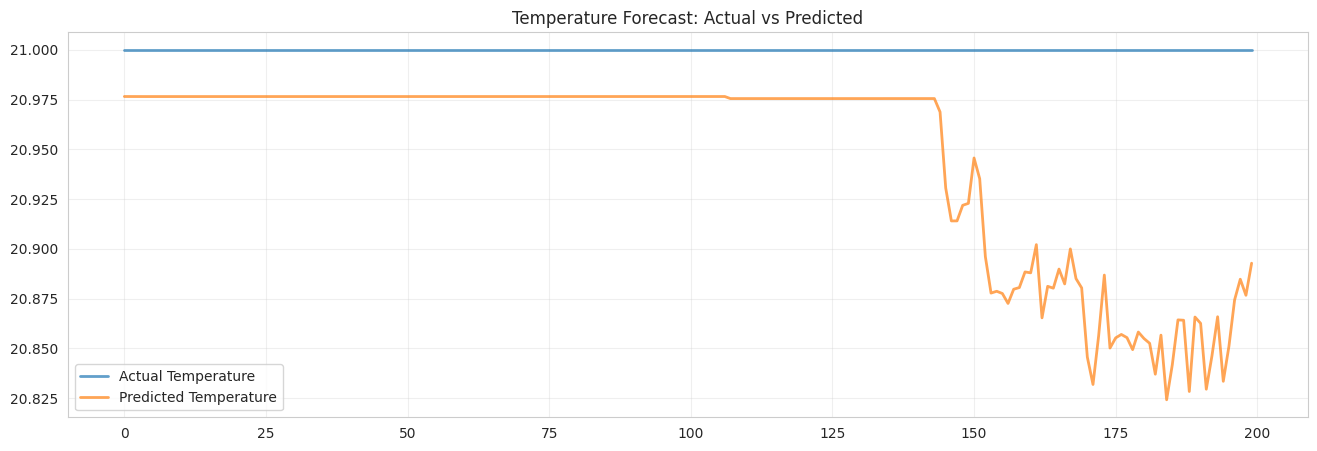

In [9]:
from scipy import stats

y_test_pred = multi_model.predict(X_test_multi_scaled)
y_test_pred_temp, y_test_pred_hum = y_test_pred.T

temp_metrics = calculate_metrics(y_test_temp, y_test_pred_temp)
hum_metrics = calculate_metrics(y_test_hum, y_test_pred_hum)

print("Test Metrics (Temp): MAE {:.4f}°C, RMSE {:.4f}°C, R² {:.4f}".format(*[temp_metrics[k] for k in ['MAE', 'RMSE', 'R²']]))
print("Test Metrics (Hum): MAE {:.4f}, RMSE {:.4f}, R² {:.4f}".format(*[hum_metrics[k] for k in ['MAE', 'RMSE', 'R²']]))

temp_residuals = y_test_temp - y_test_pred_temp
hum_residuals = y_test_hum - y_test_pred_hum
print(f"\nResiduals - Temp: Mean {np.mean(temp_residuals):.4f}, Std {np.std(temp_residuals):.4f}, p-norm {stats.normaltest(temp_residuals)[1]:.4f}")
print(f"Hum: Mean {np.mean(hum_residuals):.4f}, Std {np.std(hum_residuals):.4f}, p-norm {stats.normaltest(hum_residuals)[1]:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes[0, 0].plot(multi_model.lr_temp.cost_history)
axes[0, 0].set_title('Learning Curve - Temperature')
axes[0, 0].grid(True, alpha=0.3)

y_train_pred_temp = multi_model.lr_temp.predict(X_train_multi_scaled)
axes[0, 1].scatter(y_train_temp, y_train_pred_temp, alpha=0.5)
axes[0, 1].plot([y_train_temp.min(), y_train_temp.max()], [y_train_temp.min(), y_train_temp.max()], 'r--')
axes[0, 1].set_title('Train Actual vs Predicted - Temperature')

axes[1, 0].scatter(y_test_temp, y_test_pred_temp, alpha=0.5, c='orange')
axes[1, 0].plot([y_test_temp.min(), y_test_temp.max()], [y_test_temp.min(), y_test_temp.max()], 'r--')
axes[1, 0].set_title('Test Actual vs Predicted - Temperature')

residuals = y_test_temp - y_test_pred_temp
axes[1, 1].scatter(y_test_pred_temp, residuals, alpha=0.5, c='green')
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title('Residuals - Temperature')
plt.tight_layout()
plt.show()

# Time Series Plot  for first 200 test samples
plt.figure(figsize=(16, 5))
plt.plot(y_test_temp[:200], label='Actual Temperature', linewidth=2, alpha=0.7)
plt.plot(y_test_pred_temp[:200], label='Predicted Temperature', linewidth=2, alpha=0.7)
plt.title('Temperature Forecast: Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

- ### Multi-Step Forecast for both Temperature and Humidity

Forecasted 17640 steps (up to 7 days).

7-Day Sample (last 5):
                      created_at  predicted_temp  predicted_hum
17635 2025-10-30 17:34:37+00:00       14.367004      41.846493
17636 2025-10-30 17:34:57+00:00       14.367003      41.846492
17637 2025-10-30 17:35:17+00:00       14.367002      41.846491
17638 2025-10-30 17:35:37+00:00       14.367001      41.846491
17639 2025-10-30 17:35:57+00:00       14.367001      41.846490


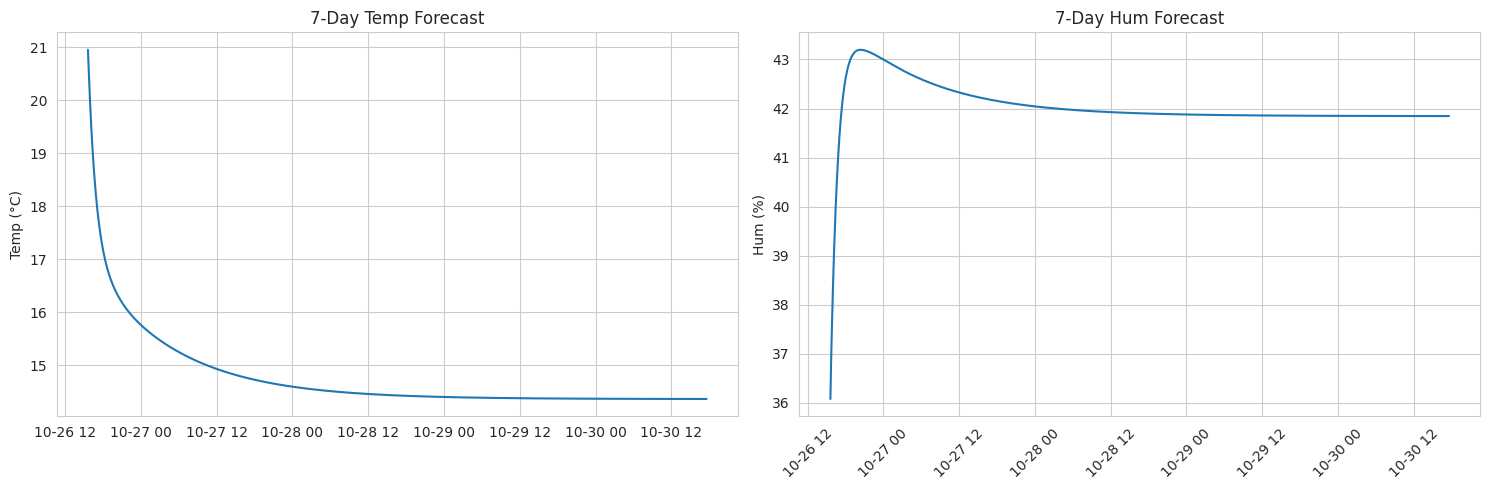

In [10]:
def multi_step_forecast(model, scaler_X, last_row_df, feature_cols, max_horizon=17640):
    predictions = {'temp': [], 'hum': []}
    future_times = []
    current_df = last_row_df.copy()
    last_time = pd.to_datetime(df_ts_multi['created_at'].iloc[-1])
    interval = pd.Timedelta(seconds=20)

    lags = sorted([int(col.split('_')[-1]) for col in feature_cols if '_lag_' in col and 'temperature' in col])

    for step in range(max_horizon):
        pred_temp, pred_hum = model.predict(scaler_X.transform(current_df[feature_cols].values.reshape(1, -1))).flatten()

        predictions['temp'].append(pred_temp)
        predictions['hum'].append(pred_hum)
        future_times.append(last_time + interval * (step + 1))

        for i in range(len(lags)-1, 0, -1):
            current_df[f'temperature_lag_{lags[i]}'] = current_df[f'temperature_lag_{lags[i-1]}'].values
            current_df[f'humidity_lag_{lags[i]}'] = current_df[f'humidity_lag_{lags[i-1]}'].values
        current_df[f'temperature_lag_{lags[0]}'] = pred_temp
        current_df[f'humidity_lag_{lags[0]}'] = pred_hum

        current_df['temperature'] = pred_temp
        current_df['humidity'] = pred_hum

        recent_temps = np.array(predictions['temp'][-20:])
        recent_hums = np.array(predictions['hum'][-20:])
        for w in [5, 10, 20]:
            if len(recent_temps) >= w:
                current_df[f'temperature_rolling_mean_{w}'] = np.mean(recent_temps[-w:])
                current_df[f'temperature_rolling_std_{w}'] = np.std(recent_temps[-w:])
                current_df[f'humidity_rolling_mean_{w}'] = np.mean(recent_hums[-w:])
                current_df[f'humidity_rolling_std_{w}'] = np.std(recent_hums[-w:])

    future_df = pd.DataFrame({
        'created_at': future_times,
        'predicted_temp': predictions['temp'],
        'predicted_hum': predictions['hum']
    })
    print(f"Forecasted {len(future_df)} steps (up to 7 days).")
    return future_df

last_row = df_ts_multi.iloc[-1:][feature_cols_multi + ['temperature', 'humidity', 'created_at']].copy()
future_preds = multi_step_forecast(multi_model, scaler_X_multi, last_row, feature_cols_multi)

print("\n7-Day Sample (last 5):\n", future_preds.tail())

# Plot full 7-day
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(future_preds['created_at'], future_preds['predicted_temp'])
ax[0].set_title('7-Day Temp Forecast')
ax[0].set_ylabel('Temp (°C)')
ax[1].plot(future_preds['created_at'], future_preds['predicted_hum'])
ax[1].set_title('7-Day Hum Forecast')
ax[1].set_ylabel('Hum (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

future_preds.to_csv('future_predictions_7days.csv', index=False)


## k-Nearest Neighbors Algorithm for Classification

In [11]:
class KNearestNeighbors:
    def __init__(self, k=5, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def _manhattan_distance(self, x1, x2):
        return np.sum(np.abs(x1 - x2))

    def _calculate_distance(self, x1, x2):
        if self.distance_metric == 'euclidean':
            return self._euclidean_distance(x1, x2)
        return self._manhattan_distance(x1, x2)

    def predict_single(self, x):
        distances = [self._calculate_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return Counter(k_nearest_labels).most_common(1)[0][0]

    def predict(self, X):
        return np.array([self.predict_single(x) for x in X])

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

class WeightedKNearestNeighbors(KNearestNeighbors):
    def __init__(self, k=5, distance_metric='euclidean', weights='uniform'):
        super().__init__(k, distance_metric)
        self.weights = weights

    def predict_single(self, x):
        distances = np.array([self._calculate_distance(x, x_train) for x_train in self.X_train])
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train[k_indices]
        k_distances = distances[k_indices]
        if self.weights == 'distance':
            wts = 1 / (k_distances + 1e-5)
            class_votes = Counter({label: 0 for label in np.unique(k_nearest_labels)})
            for label, wt in zip(k_nearest_labels, wts):
                class_votes[label] += wt
            return max(class_votes, key=class_votes.get)
        return super().predict_single(x)

- ### Prepare Datasets and Labels

Class dist:
 environment_state
Tilted    13544
Dark       3782
Hot         295
Humid       184
Normal       14
Name: count, dtype: int64


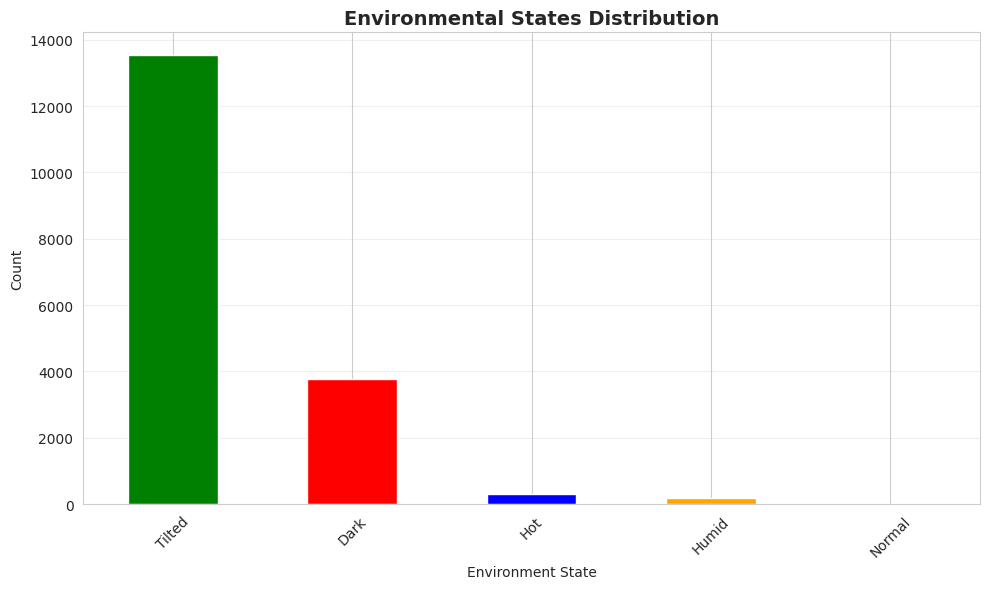

Train: 14255, Test: 3564


In [18]:
def create_environmental_labels(df):
    labels = []
    for _, row in df.iterrows():
        if row['temperature'] > 30:
            labels.append('Hot')
        elif row['humidity'] > 65:
            labels.append('Humid')
        elif row['light_level'] < 5:
            labels.append('Dark')
        elif row['tilt_status'] == 1:
            labels.append('Tilted')
        else:
            labels.append('Normal')
    return np.array(labels)



df_class = df_cleaned.copy()
df_class['environment_state'] = create_environmental_labels(df_class)
class_counts = df_class['environment_state'].value_counts()
print("Class dist:\n", class_counts)

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color=['green', 'red', 'blue', 'orange', 'purple'])
plt.title('Environmental States Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Environment State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

feature_cols_knn = ['temperature', 'humidity', 'light_level', 'tilt_status']
X_class = df_class[feature_cols_knn].values
y_class = df_class['environment_state'].values

train_size = int(0.8 * len(X_class))
X_train_knn, y_train_knn = X_class[:train_size], y_class[:train_size]
X_test_knn, y_test_knn = X_class[train_size:], y_class[train_size:]

scaler_knn = StandardScaler()
X_train_knn_scaled = scaler_knn.fit_transform(X_train_knn)
X_test_knn_scaled = scaler_knn.transform(X_test_knn)

print(f"Train: {len(X_train_knn)}, Test: {len(X_test_knn)}")

- ### Optimal k Value and Cross Validation

Best k: 1 (Acc: 0.9997)


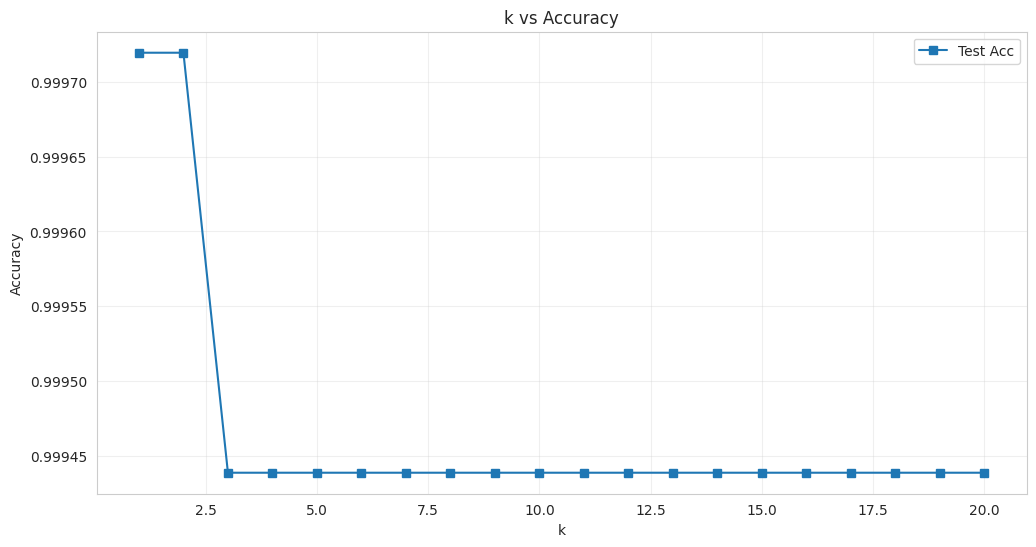


 Optimal k value: 1
  Best test accuracy: 0.9997
CV (k=1, weighted): 0.9996 ± 0.0004


In [ ]:
k_values = range(1, 21)
test_scores = [KNearestNeighbors(k=k).fit(X_train_knn_scaled, y_train_knn).score(X_test_knn_scaled, y_test_knn) for k in k_values]
best_k = k_values[np.argmax(test_scores)]
print(f"Best k: {best_k} (Acc: {max(test_scores):.4f})")

plt.figure(figsize=(12, 6))
plt.plot(k_values, test_scores, marker='s', label='Test Acc')
plt.title('k vs Accuracy')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

best_k_idx = np.argmax(test_scores)
best_k = k_values[best_k_idx]
best_accuracy = test_scores[best_k_idx]

print(f"\n Optimal k value: {best_k}")
print(f"  Best test accuracy: {best_accuracy:.4f}")

from sklearn.model_selection import KFold
def cross_validate_knn(X, y, k, folds=5, weights='distance'):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    cv_scores = []
    for train_idx, val_idx in kf.split(X):
        knn_cv = WeightedKNearestNeighbors(k=k, weights=weights)
        knn_cv.fit(X[train_idx], y[train_idx])
        cv_scores.append(knn_cv.score(X[val_idx], y[val_idx]))
    return np.mean(cv_scores), np.std(cv_scores)

cv_mean, cv_std = cross_validate_knn(X_train_knn_scaled, y_train_knn, best_k)
print(f"CV (k={best_k}, weighted): {cv_mean:.4f} ± {cv_std:.4f}")

- ### Train, Metrics and Confusion Matrix

Train Acc: 1.0000 | Test Acc: 0.9997

Test P/R per class:
Dark            0.9992       1.0000      
Tilted          1.0000       0.9996      


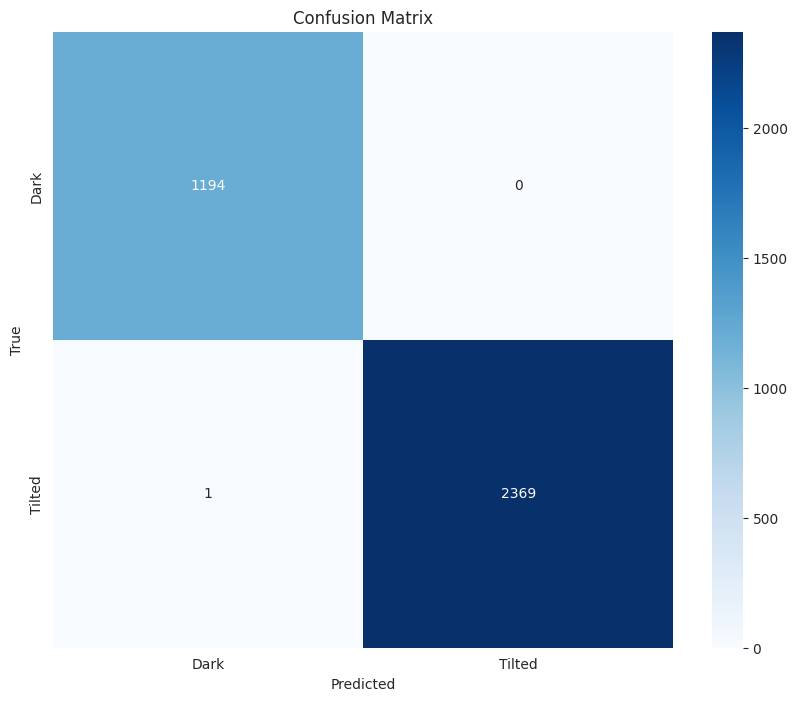

In [ ]:
def calculate_classification_metrics(y_true, y_pred):
    accuracy = np.mean(y_true == y_pred)
    classes = np.unique(y_true)
    precision, recall = {}, {}
    for cls in classes:
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fp = np.sum((y_true != cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))
        precision[cls] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[cls] = tp / (tp + fn) if (tp + fn) > 0 else 0
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall}

def create_confusion_matrix(y_true, y_pred, classes):
    n_classes = len(classes)
    cm = np.zeros((n_classes, n_classes), dtype=int)
    class_to_idx = {cls: i for i, cls in enumerate(classes)}
    for true, pred in zip(y_true, y_pred):
        cm[class_to_idx[true], class_to_idx[pred]] += 1
    return cm

# Train final (weighted)
knn_final = WeightedKNearestNeighbors(k=best_k, weights='distance')
knn_final.fit(X_train_knn_scaled, y_train_knn)
y_train_pred_knn = knn_final.predict(X_train_knn_scaled)
y_test_pred_knn = knn_final.predict(X_test_knn_scaled)

train_metrics = calculate_classification_metrics(y_train_knn, y_train_pred_knn)
test_metrics = calculate_classification_metrics(y_test_knn, y_test_pred_knn)
print(f"Train Acc: {train_metrics['accuracy']:.4f} | Test Acc: {test_metrics['accuracy']:.4f}")

print("\nTest P/R per class:")
for cls in test_metrics['precision'].keys():
    precision = test_metrics['precision'][cls]
    recall = test_metrics['recall'][cls]
    print(f"{cls:<15} {precision:<12.4f} {recall:<12.4f}")

# Confusion
classes = np.unique(y_test_knn)
cm = create_confusion_matrix(y_test_knn, y_test_pred_knn, classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

- ### Distance Metrics Comparison

In [ ]:
metrics_comparison = {}

for metric in ['euclidean', 'manhattan']:
    knn_metric = KNearestNeighbors(k=best_k, distance_metric=metric)
    knn_metric.fit(X_train_knn_scaled, y_train_knn)

    test_accuracy = knn_metric.score(X_test_knn_scaled, y_test_knn)
    metrics_comparison[metric] = test_accuracy

    print(f"{metric.capitalize()} Distance: {test_accuracy:.4f}")


Euclidean Distance: 0.9997
Manhattan Distance: 0.9994


# Summary and Save Results

In [ ]:
print("\nPROJECT SUMMARY")

print(f"1. Isolation Forest: {n_anomalies} anomalies ({anomaly_percentage:.1f}%)")
print(f"2. Linear Reg: Temp MAE {temp_metrics['MAE']:.4f}°C, Hum MAE {hum_metrics['MAE']:.4f}%")
print(f"3. k-NN: Acc {test_metrics['accuracy']:.4f} (k={best_k}, weighted)")

# Save
df_cleaned.to_csv('feeds_with_predictions.csv', index=False)
summary = {
    'Isolation_Forest': {'Anomalies': n_anomalies, 'Percentage': anomaly_percentage, 'Threshold': threshold},
    'Linear_Regression': {**temp_metrics, **hum_metrics},
    'KNN': {'Best_k': best_k, 'Accuracy': test_metrics['accuracy'], 'Weights': 'distance'}
}
def convert_to_python_types(obj):
    if isinstance(obj, dict):
        return {k: convert_to_python_types(v) for k, v in obj.items()}
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, list):
        return [convert_to_python_types(v) for v in obj]
    else:
        return obj

summary_py = convert_to_python_types(summary)
import json
with open('summary.json', 'w') as f:
    json.dump(summary_py, f, indent=4)
print("\nSaved results.")


PROJECT SUMMARY
1. Isolation Forest: 180 anomalies (1.0%)
2. Linear Reg: Temp MAE 0.0405°C, Hum MAE 0.1174%
3. k-NN: Acc 0.9997 (k=1, weighted)

Saved results.
